This notebook loads the data from trajectory_analysis_script.py for whichever data set is needed. The point is to look at the density of the tracks/localizations per area of the cell.

In [ ]:
from src.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
import os
from src.helpers.plotting_functions import *
from src.helpers.import_functions import *
from src.helpers.Analysis_functions import *
from src.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
from src.helpers.scalebars import *
from src.helpers.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats  
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import src.helpers.simulate_foci as simulate_foci
from sklearn.cluster import DBSCAN
from cgitb import small
import src.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.helpers.guassian_fit as gaussian_fit

In [ ]:
%matplotlib widget

In [ ]:
%matplotlib widget
sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 5,
                            center = [25.,25.],
                            total_points = 100,
                            density_dif = 100000000.0,
                            pdf = simulate_foci.tophat_function_2d)
sim.uniform_uniform_blob = True
sim.psf_sigma = 0.82
map,sim_xy = sim.simulate_point()
map = np.array(map)
#map += np.random.rand(*np.shape(map))*np.max(map)/100

x,y = np.meshgrid(np.arange(0,50),np.arange(0,50))
# fig = plt.figure()
# # ax = plt.axes(projection='3d')
# # ax.plot_wireframe(x,y,map)
# # ax.set_xlim((10,30))
# # ax.set_ylim((10,30))
# # plt.show()
def dim_dif_total(radi,points):
    maps = []
    for i in points:
        sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = radi,
                            center = [25.,25.],
                            total_points = int(i),
                            density_dif = 100000000.0,
                            pdf = simulate_foci.tophat_function_2d)
        sim.uniform_uniform_blob = True
        sim.psf_sigma = 0.82
        map,sim_xy = sim.simulate_point()
        maps.append(np.array(map))
    return maps
# maps = dim_dif_total(3,[1e1])
# plt.clf()
# def normalize_2d(a):
#     row_sums = a.sum(axis=1)
#     new_matrix = a / row_sums[:, np.newaxis]
#     return new_matrix
# for i in maps:
#     plt.contour(x,normalize_2d(i),y,label = "points = {0}".format(i))
# plt.legend()
# plt.show()

In [ ]:
plt.clf()
a = simulate_foci.generate_sphere_points(500,[1,1,1],10)
b = simulate_foci.generate_radial_points(500,[1,1],10)
fig,ax = plt.subplots(2,sharex=True,sharey=True)
ax[0].plot(a[:,0],a[:,1],'o')
ax[1].plot(b[:,0],b[:,1],'o')
cir = Circle((1,1),10,fill = False)
ax[0].add_patch(cir)
cir2 = Circle((1,1),10,fill = False)
ax[1].add_patch(cir2)
plt.show()



In [ ]:

sim = simulate_foci.sim_foci(max_x = 50,
                            min_x = 0,
                            radius = 2,
                            center = [25.,25.],
                            total_points = 1,
                            density_dif = 100000000.0,
                            pdf = simulate_foci.tophat_function_2d)
sim.uniform_blob = True
sim.psf_sigma = 1.64
map,sim_xy = sim.simulate_point(generator = None)

map = np.array(map)
b = blob_detection(path = map,\
                    median= False,\
                    threshold= 1e-20, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 1000, \
                    overlap = 0, \
                    logscale=False)
b._update_fitting_parameters(kwargs={"mask_size":5,
                            "plot_fit":True,
                            "fitting_image":"Original",
                            "radius_func":None,
                            "sigma_range":1,
                            "centroid_range":2})
c = b.detection(type = "bp")
#print(c)
print(len(c))
print(c)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(map,cmap="gray")
for i in c:
    cir = plt.Circle((i[1],i[0]),i[2],fill = False)
    ax.add_artist(cir)
    cir = plt.Circle((i[1],i[0]),0.1,fill = True)
    ax.add_artist(cir)
for i in sim_xy:
    cir = plt.Circle((i[0],i[1]),0.1,fill = True,edgecolor = "orange")
    ax.add_artist(cir)
#cir = plt.Circle((sim.center[0],sim.center[1]),c[2],fill = True,edgecolor = "Blue")
plt.show()
#print(sim_xy)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(bin_img(map,bin=2,operation='mean'),cmap="gray")
plt.show()


In [ ]:
plt.clf()
plt.plot(c[:,0],c[:,1],'r.',label = "Fitted xy")
plt.plot(sim_xy[:,1],sim_xy[:,0],'g.',label="True xy")
plt.xlabel("x val")
plt.ylabel("y val")
plt.legend()
plt.show()

In [ ]:
blob_psf = 1.*np.sqrt(2)*130
num_blobs = np.arange(1,len(c)+1,1)
plt.clf()
plt.plot(num_blobs,(c[:,2]*130 - blob_psf),'r.',label = "Fitted blob radius")
plt.xlabel("particle ID")
plt.ylabel("Percent Error of Fitted Blob Radius From Expected Psf Radius")
plt.legend()
plt.show()

In [ ]:
#isotropic residual gaussain
def iso_gaus(p,x,y,z):
    p["sigma_x"] = p["sigma_y"]
    return residuals_gaus2d(p,x,y,z)

In [ ]:
radii = np.linspace(0.5,4.5,20)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":500,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":np.mean,
                "residual_func":residuals_gaus2d,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.2,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}
a = simulate_foci.sim_focii(radii=radii,repeats=5,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
a.use_points = True
c = a.radius_analysis()
print(c)

In [ ]:
print(radii)

In [ ]:

min_rp_rad = 206.2 #nm
max_rp_rad = 375.0 #nm

min_ll_rad = 160.7 #nm
max_ll_rad = 252.0 #nm

min_rad = np.min(np.asarray(radii)*130)
max_rad = np.max(np.asarray(radii)*130)

plt.clf()
plt.errorbar(np.asarray(radii)*130,130*np.asarray(c["fit_mean"]),yerr=130*np.asarray(c["fit_stds"]),label = "Gaussian Fit")
plt.errorbar(np.asarray(radii)*130,130*np.asarray(c["sig_mean"]),yerr=130*np.asarray(c["sig_std"]), label = "Scale-Space")
#plt.plot(np.asarray(radii)*130,np.asarray(radii)*130,label = "True")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
# plt.ylim((0,4)) 
# plt.xlim((0,4))

plt.ylabel("Found Radius (nm)")
plt.xlabel("Simulated Radius (nm)")
plt.hlines([min_rp_rad,max_rp_rad],min_rad,max_rad)
plt.fill_between([min_rad,max_rad],[min_rp_rad,min_rp_rad],[max_rp_rad,max_rp_rad],color = 'red', alpha=0.2,label = "rp_ez Radii Spread")
plt.hlines([min_ll_rad,max_ll_rad],min_rad,max_rad)
plt.fill_between([min_rad,max_rad],[min_ll_rad,min_ll_rad],[max_ll_rad,max_ll_rad],color = 'green', alpha=0.2,label = "ll_ez Radii Spread")
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.errorbar(np.asarray(radii)*130,100*np.abs(np.asarray(c["fit_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["fit_stds"])/np.asarray(radii),label = "Gaussian Fit")
plt.errorbar(np.asarray(radii)*130,100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["sig_std"])/np.asarray(radii),label = "Space-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
#print(radius/np.sqrt(2),found_radius,std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")

plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
plt.legend()
plt.show()


In [ ]:
plt.clf()
plt.errorbar((np.asarray(radii))*130,(np.asarray(c["fit_mean"])-np.asarray(radii))*130,yerr=130*(np.asarray(c["fit_stds"])))
plt.errorbar((np.asarray(radii))*130,(np.asarray(c["sig_mean"])-np.asarray(radii))*130,yerr=130*(np.asarray(c["sig_std"])))
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
#print(radius/np.sqrt(2),found_radius,130*std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.legend()
#plt.yscale("log")
plt.ylabel("Error from True (nm)")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red')
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green')
plt.show()

In [ ]:
########## changing points simulated for each radius
radii = np.linspace(0.5,4.5,10)
sim_args = {"max_x":50,
            "min_x":0,
            "center":[25,25],
            "total_points":500,
            "density_dif":1e7,
            "pdf":simulate_foci.tophat_function_2d,
            "uniform":True,
            "psf_sigma":0.82}
detection_args = {"median":False,
                "threshold":1e-2,
                "min_sigma":1./np.sqrt(2),
                "max_sigma":10./np.sqrt(2),
                "num_sigma":200,
                "overlap":0,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":5,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":squared_mean_difference,
                "residual_func":iso_gaus,
                "sigma_range":2}
track_args = {"track_length_mean":10,
            "track_type":"fbm",
            "track_hurst":0.35,
            "track_distribution":"uniform",
            "diffusion_coefficient":1e-2}
a = simulate_foci.sim_focii(radii=radii,repeats=3,detection_kwargs=detection_args,sim_kwargs=sim_args,fitting_parm=fitting_args,track_parm=track_args)
a.use_points=False
total_points = np.arange(100,901,200) + 1
data_store = {}
for i in total_points:
    data_store[i] = a.total_points_radius_analysis(total_points=i)


In [ ]:
print(data_store)

In [ ]:
plt.clf()
for i,c in data_store.items():
    #plt.clf()
    #plt.errorbar(np.asarray(radii)*130,100*np.abs(np.asarray(c["fit_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["fit_stds"])/np.asarray(radii),label = "Gaussian Fit Points:{0}".format(i))
    plt.errorbar(np.asarray(radii)*130,100*np.abs(np.asarray(c["sig_mean"])-np.asarray(radii))/np.asarray(radii),yerr=100*np.asarray(c["sig_std"])/np.asarray(radii),label = "Space-Space Points:{0}".format(i))
    #plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
    #print(radius/np.sqrt(2),found_radius,std_radius)
    # plt.ylim((0,4))
    # plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
plt.ylim((-5,150))
plt.legend()
plt.show()

In [ ]:
def sim_radius_range(radius,avg=10,psf_sigma=1,radius_func=None,mask_size=5,plot_fit=True,fitting_image="original",residual_func=iso_gaus):
    mean_rads = np.zeros(len(radius))
    std_rads = np.zeros(len(radius))
    mean_rads_sig = np.zeros(len(radius))
    std_rads_sig = np.zeros(len(radius))
    for i,j in enumerate(radius):
        avg_mean = []
        avg_mean_sig = []
        for k in range(avg):
            sim = simulate_foci.sim_foci(max_x = 50,
                                min_x = 0,
                                radius = j,
                                center = [25.,25.],
                                total_points = 500,
                                density_dif = 1e7,
                                pdf = simulate_foci.tophat_function_2d,
                                uniform = True)
            sim.uniform_blob = True
            sim.psf_sigma = psf_sigma
            map,sim_xy = sim.simulate_point()
            map = np.array(map)
            b = blob_detection(path = map,\
                        median= False,\
                        threshold= 1e-2, \
                        min_sigma= 1/np.sqrt(2), \
                        max_sigma = max(radius)+5/np.sqrt(2), \
                        num_sigma= 500, \
                        overlap = 0, \
                        logscale=False)
            b.verbose = True
            b._update_fitting_parameters(kwargs={"mask_size":mask_size,
                                        "plot_fit":plot_fit,
                                        "fitting_image":fitting_image,
                                        "radius_func":radius_func,
                                        "residual_func":residual_func})
            c = b.detection(type = "bp")
            avg_mean.append(np.mean(c[0][:,-1]))
            avg_mean_sig.append(np.mean(c[1][:,-1]))
        print("Done {0} step".format(i))
        mean_rads[i] = np.mean(avg_mean)
        std_rads[i] = np.std(avg_mean)
        mean_rads_sig[i] = np.mean(avg_mean_sig)
        std_rads_sig[i] = np.std(avg_mean_sig)
    return mean_rads,std_rads,mean_rads_sig,std_rads_sig

radius = np.linspace(0.6,5,10)
found_radius,std_radius,found_radius_sig,std_radius_sig = sim_radius_range(radius=radius,
                                        psf_sigma=0.82,
                                        radius_func=np.mean,
                                        mask_size=10,
                                        plot_fit=False,
                                        fitting_image="Original",
                                        residual_func=iso_gaus,avg=10)
    

In [ ]:
print(found_radius,std_radius,found_radius_sig,std_radius_sig)

radius = np.linspace(0.6,5,10)
min_rp_rad = 206.2 #nm
max_rp_rad = 375.0 #nm

min_ll_rad = 160.7 #nm
max_ll_rad = 252.0 #nm

min_rad = np.min(np.asarray(radius)*130)
max_rad = np.max(np.asarray(radius)*130)

plt.clf()
plt.errorbar(np.asarray(radius)*130,130*np.asarray(found_radius),yerr=130*np.asarray(std_radius),label = "Gaussian Fit")
plt.errorbar(np.asarray(radius)*130,130*np.asarray(found_radius_sig),yerr=130*np.asarray(std_radius_sig), label = "Scale-Space")
plt.plot(np.asarray(radii)*130,np.asarray(radii)*130,label = "True")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
print(radius*130,found_radius*130,std_radius*130)
# plt.ylim((0,4)) 
# plt.xlim((0,4))
plt.ylabel("Found Radius (nm)")
plt.xlabel("Simulated Radius (nm)")
plt.hlines([min_rp_rad,max_rp_rad],min_rad,max_rad)
plt.fill_between([min_rad,max_rad],[min_rp_rad,min_rp_rad],[max_rp_rad,max_rp_rad],color = 'red', alpha=0.2,label = "rp_ez Radii Spread")
plt.hlines([min_ll_rad,max_ll_rad],min_rad,max_rad)
plt.fill_between([min_rad,max_rad],[min_ll_rad,min_ll_rad],[max_ll_rad,max_ll_rad],color = 'green', alpha=0.2,label = "ll_ez Radii Spread")
plt.legend()
plt.show()


In [ ]:
plt.clf()
plt.errorbar(np.asarray(radius)*130,100*np.abs(np.asarray(found_radius)-np.asarray(radius))/np.asarray(radius),yerr=100*np.asarray(std_radius)/np.asarray(radius),label = "Gaussian Fit")
plt.errorbar(np.asarray(radius)*130,100*np.abs(np.asarray(found_radius_sig)-np.asarray(radius))/np.asarray(radius),yerr=100*np.asarray(std_radius_sig)/np.asarray(radius),label = "Space-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
print(radius/np.sqrt(2),found_radius,std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.ylabel("Percent Error")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red',label = "rp_ez_spread")
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green',label = "ll_ez_spread")
plt.legend()
plt.show()



In [ ]:
plt.clf()
plt.errorbar((np.asarray(radius)-0.82*np.sqrt(2))*130,(np.asarray(found_radius)-0.82*np.sqrt(2))*130,yerr=130*(np.asarray(std_radius)),label = "Gaussian Fit")
plt.errorbar((np.asarray(radius)-0.82*np.sqrt(2))*130,(np.asarray(found_radius_sig)-0.82*np.sqrt(2))*130,yerr=130*(np.asarray(std_radius_sig)),label = "Scale-Space")
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
print(radius/np.sqrt(2),found_radius,std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.legend()
plt.ylabel("Found Radius relative to diffraction radius (nm)")
plt.xlabel("Simulated Radius relative to diffraction radius (nm)")
plt.show()

In [ ]:
plt.clf()
plt.errorbar((np.asarray(radius))*130,(np.asarray(found_radius)-np.asarray(radius))*130,yerr=130*(np.asarray(std_radius)))
plt.errorbar((np.asarray(radius))*130,(np.asarray(found_radius_sig)-np.asarray(radius))*130,yerr=130*(np.asarray(std_radius_sig)))
#plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),'r-')
print(radius/np.sqrt(2),found_radius,130*std_radius)
# plt.ylim((0,4))
# plt.xlim((0,4))
plt.legend()
plt.ylabel("Error from True (nm)")
plt.xlabel("Simulated Radius (nm)")
plt.axvspan(min_rp_rad, max_rp_rad, alpha=0.2, color='red')
plt.axvspan(min_ll_rad, max_ll_rad, alpha=0.2, color='green')
plt.show()

In [ ]:
os.chdir("..")


In [4]:
rp_ez= run_analysis(wd="/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/DATA/new_days/20190527/rpoc_ez",
                    t_string="rpoc_ez")
                    
rp_ez.read_parameters(minimum_percent_per_drop_in = 0.9, 
                    t_len_u = 100, 
                    t_len_l=10, 
                    minimum_tracks_per_drop = 3)

rp_ez.get_blob_parameters(threshold=1e-4,
                        overlap=0,
                        detection_name='bp',
                        min_sigma=1/np.sqrt(2),
                        max_sigma=6/np.sqrt(2),
                        num_sigma=500,median = False)

rp_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":identity,
                                    "residual_func":residuals_gaus2d,
                                    "sigma_range":2,
                                    "centroid_range":0.5,
                                    "height_range":2})
rp_ez.run_flow()

[[111.63392337 138.12374933   1.8815927    2.17836186]
 [114.27969586 126.17044028   1.6180506    1.40170085]
 [ 93.70391623  43.99814557   2.07399726   2.56119746]
 [106.70764249  44.63850354   1.87213778   2.87213778]
 [131.5         32.5          2.62317304   3.62317304]
 [109.72507847  35.19490966   2.26091302   1.93347233]]
[[ 90.54078609  46.59578009   0.37105272   1.20710678]
 [111.24680301  35.26154047   2.62317304   3.62317304]
 [108.87604483  44.99128594   1.99658734   2.62415444]]
[[112.47262547  34.58465736   2.36810446   3.36810446]
 [105.5         46.77300348   3.36810446   2.55556624]
 [112.5        139.94512053   3.62317304   2.62317304]
 [100.19661336  47.5          0.77741715   0.97633541]]
[[124.30166632  35.29482084   1.20608479   1.20710678]
 [116.15475896 130.7222005    1.36908586   1.52414898]
 [105.67243248  49.1357126    1.70971493   2.12191109]
 [126.2766089   96.99083927   1.053441     0.95985745]
 [112.54221258 137.51480298   1.20710678   0.98836818]
 [111.5

In [5]:
def get_radius(dataset,plot=True,bins=5):
    radius = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.Drop_Collection.items():
                radius.append(n[2])
    radius = np.array(radius)
    radius = radius[radius>0.]
    radius_rp_ez = np.array(radius)*130
    rad = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.All_Drop_Collection.items():
                rad.append(n[2])
    rad = np.array(rad)
    rad = rad[rad>0.]
    rad = rad*130
    if plot:
        plt.hist(radius_rp_ez,alpha = 0.1,label = "viable",bins=bins)
        plt.hist(rad,alpha = 0.1, label = "All",bins=bins)
        plt.xlabel("Radius in um")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    return [radius_rp_ez,rad]

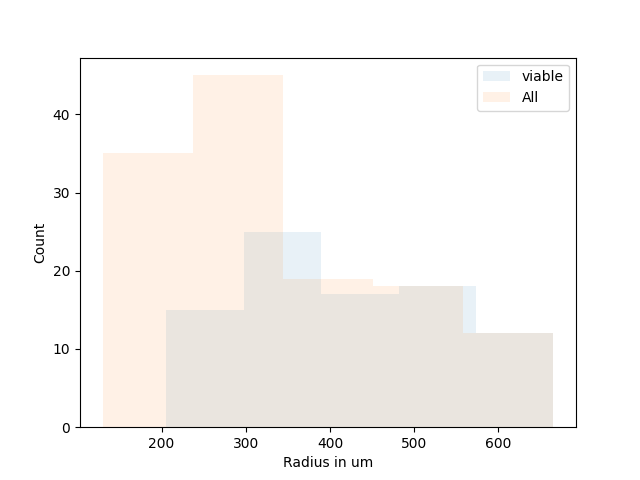

In [6]:
plt.clf()
viable_rp,all_rp = get_radius(rp_ez)

In [7]:
def _avg_points_drop(dataset):
    drop_locs = {}
    total_locs = {}
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            sorted_tracks = rp_ez._convert_track_frame(np.array(l.raw_tracks),t_len_l=1,t_len_u = 100)
            for m,n in l.Drop_Collection.items():
                counter = 0
                total_localizations = 0
                x,y = sorted_tracks[1],sorted_tracks[2]
                for tt in range(len(x[int(m[0])])):
                    for ttt in range(len(x[int(m[0])][tt])):
                        total_localizations+=1
                        if point_inside_circle2D(n,[x[int(m[0])][tt][ttt],y[int(m[0])][tt][ttt]]):
                            counter+=1
                drop_locs["{0},{1},{2}".format(i,k,m)] = counter
                total_locs["{0},{1},{2}".format(i,k,m)] = total_localizations
    return drop_locs,total_locs

drop_localizations,total_localizations = _avg_points_drop(rp_ez)
print(drop_localizations)
avg_drop_localizations = np.mean(list(drop_localizations.values()))
std_drop_localizations = np.std(list(drop_localizations.values()))
print(avg_drop_localizations,std_drop_localizations,np.mean(list(total_localizations.values())),np.std(list(total_localizations.values())))              

{'0,0,0,4': 579, '0,0,0,5': 273, '0,0,1,1': 415, '0,0,2,0': 387, '0,0,4,1': 398, '0,0,4,3': 463, '0,1,0,2': 248, '0,1,0,3': 594, '0,1,1,2': 307, '0,1,2,1': 499, '0,1,3,2': 416, '0,2,3,3': 281, '0,3,0,0': 679, '0,3,2,2': 638, '0,3,3,1': 402, '0,3,3,5': 367, '0,3,4,0': 404, '1,0,0,2': 372, '1,0,0,4': 315, '1,1,0,0': 320, '1,1,0,1': 544, '1,3,1,2': 269, '1,4,0,3': 502, '1,5,3,0': 372, '1,6,3,1': 253, '1,6,4,1': 391, '1,7,1,1': 417, '1,7,2,0': 251, '1,7,3,1': 245, '1,7,3,3': 305, '2,0,0,1': 559, '2,0,2,0': 490, '2,1,0,5': 240, '2,2,0,0': 863, '2,2,0,2': 413, '2,2,4,0': 528, '2,3,0,3': 414, '3,0,0,1': 466, '3,0,3,1': 434, '3,1,0,2': 272, '3,2,0,3': 229, '3,2,0,4': 238, '3,2,0,6': 245, '3,2,1,0': 271, '3,3,0,0': 264, '3,3,0,5': 372, '3,3,0,6': 296, '3,3,3,0': 507, '4,0,0,0': 383, '4,0,0,5': 343, '4,0,0,6': 261, '4,0,0,7': 328, '4,0,2,1': 433, '4,1,0,2': 484, '4,1,0,6': 295, '4,1,1,0': 438, '4,2,0,3': 594, '4,2,1,1': 414, '4,2,2,2': 479, '4,2,3,0': 637, '4,2,3,4': 264, '5,0,3,0': 503, '5,0,4,

In [ ]:
movie_ID = '0'
a = rp_ez.Movie[movie_ID].Movie_nucleoid
b = blob_detection(path = a,\
                    median= True,\
                    threshold= 0.05, \
                    min_sigma= 1/sqrt(2), \
                    max_sigma = 3./sqrt(2), \
                    num_sigma= 100, \
                    overlap = 0)
c = b.detection()
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(aa,cmap = 'Greys')
# for i in c:
#     cir = plt.Circle((i[1],i[0]),radius=i[2], fill = False)
#     ax.add_artist(cir)
plt.show()


In [ ]:
print(rp_ez.Movie[movie_ID].Movie_nucleoid)


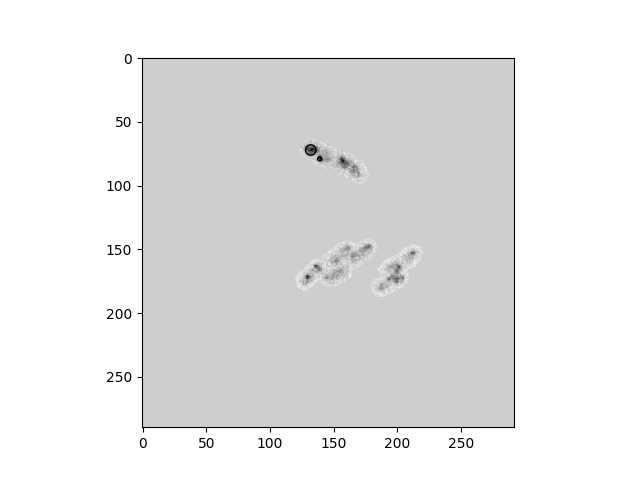

{'0,0': array([139.        ,  79.        ,   1.58116232]), '0,1': array([132.        ,  72.        ,   4.05611222])}
{'0,0': {'Fitted': array([138.83718482,  79.02395271,   1.59082193,   1.84395044]), 'Scale': array([139.        ,  79.        ,   1.58116232]), 'Fit': <lmfit.minimizer.MinimizerResult object at 0x29a3ef130>}, '0,1': {'Fitted': array([132.12835366,  72.14346155,   4.76321901,   3.34900544]), 'Scale': array([132.        ,  72.        ,   4.05611222]), 'Fit': <lmfit.minimizer.MinimizerResult object at 0x29a3ec7f0>}}
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 9
    # data points      = 36
    # variables        = 6
    chi-square         = 247.275076
    reduced chi-square = 8.24250252
    Akaike info crit   = 81.3713680
    Bayesian info crit = 90.8724816
[[Variables]]
    height:      26.0000000 +/- 9.03909433 (34.77%) (init = 24)
    centroid_x:  72.1434616 +/- 0.23400571 (0.32%) (init = 72)
    centroid_y:  132.128354 +/- 0.1222939

In [15]:
from scipy.ndimage import filters
%matplotlib widget
#fig,ax = run_analysis_plotting.plot_img(rp_ez,1,movie_ID,1,int("0,2"[0]))
a =rp_ez._get_movie_path('1',0)
b = blob_detection(path = a,\
                    median= True,\
                    threshold= 1e-4, \
                    min_sigma= 1, \
                    max_sigma = 3.5, \
                    num_sigma= 500, \
                    overlap = 0.8)
c = b.detection(type = 'bp')
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
#ax.imshow(filters.median_filter(aa,size =1),cmap = 'Greys')
ax.imshow(aa,cmap = 'Greys')
for i in rp_ez.Movie['1'].Cells['1'].All_Drop_Collection.values():
    cir = plt.Circle((i[0],i[1]),radius=i[2], fill = False)
    ax.add_artist(cir)
plt.show()
print(rp_ez.Movie['1'].Cells['1'].All_Drop_Collection)
print(rp_ez.Movie['1'].Cells['1'].All_Drop_Verbose)
print(report_fit(rp_ez.Movie['1'].Cells['1'].All_Drop_Verbose['0,1']["Fit"]))

In [ ]:
samples = [5,7,10,15,20,30]
axis_x = 2
axis_y = 3
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,(axis_x,axis_y),all_tracks=False,cell_ID = '7',movie_ID='1')
x_y = np.array([[a,b] for a,b in zip(x,y)])
for i in range(axis_x):
    for j in range(axis_y):
        clustering = OPTICS(min_samples=samples[i*axis_x + j]).fit(x_y)
        a = ax[i,j].scatter(x,y,s= 1,c = clustering.labels_)
fig.colorbar(a)
fig.tight_layout()
plt.show()

In [ ]:
for i in samples:
    clustering = OPTICS(min_samples=i).fit(x_y)
    a = plt.scatter(x,y,s= 1,c = clustering.labels_)
    plt.colorbar(a)
    plt.title("min_samples = {0}".format(i))
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
sim = simulate_foci.sim_foci(max_x = 200,
                            min_x = 0,
                            radius = 50,
                            center = [100,100],
                            total_points = 500,
                            density_dif = 5.0,
                            pdf = simulate_foci.tophat_function_2d)
sim_xy = sim._makePoints()
for i in samples:
    clustering = OPTICS(min_samples=i).fit(sim_xy)
    fig = plt.figure()
    ax = fig.add_subplot()
    a = ax.scatter(sim_xy[:,0],sim_xy[:,1],s= 2,c = clustering.labels_)
    plt.colorbar(a)
    cir = plt.Circle(sim.center,radius = sim.radius,fill = False)
    ax.set_title("min_samples = {0}".format(i))
    ax.add_artist(cir)

In [ ]:
#%matplotlib qt 
#train data on the best of above: samples = 30
clustering_fit = DBSCAN(min_samples=30,eps = 1.0).fit(sim_xy)
print(rp_ez.Movie['1'].Cells['1'].Drop_Collection)
print(rp_ez.Movie['1'].Cells['4'].Drop_Collection)
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,cell_ID = ['1'],movie_ID='1',movie_frame_index = 0,all_tracks = 1)
x_y = np.array([[a,b] for a,b in zip(x,y)])
clustering = clustering_fit.fit_predict(x_y)
a = ax.scatter(x,y,s= 1,c = clustering)
fig.colorbar(a)
fig.tight_layout()
plt.show()
print(len(x))
fig = plt.figure()
ax = fig.add_subplot()
a = ax.scatter(x,y,s= 20,c = clustering,cmap = "Greys")
fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
clustering_fit = DBSCAN(min_samples=30,eps = 1.0).fit(sim_xy)
x,y,fig,ax=run_analysis_plotting.draw_item(rp_ez,cell_ID = ['1'],movie_ID='1',movie_frame_index = 0,all_tracks = 1)
x_y = np.array([[a,b] for a,b in zip(x,y)])
clustering = clustering_fit.fit_predict(x_y)
a = ax.scatter(x,y,s= 1,c = clustering)
fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

non_cluster = np.where((np.asarray(clustering) >= 0))[0]
# fig = plt.figure()
# ax = fig.add_subplot()
# a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
# ax.imshow(a,cmap = 'Greys')
# a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
# fig.colorbar(a)
# ax.set_xlim((120,190))
# ax.set_ylim((55,100))
# plt.gca().invert_yaxis()
# fig.tight_layout()
# plt.show()


fig = plt.figure()
ax = fig.add_subplot()
a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
ax.imshow(a,cmap = 'Greys')
a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
fig.colorbar(a)
ax.set_xlim((170,240))
ax.set_ylim((140,200))
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()


fig = plt.figure()
ax = fig.add_subplot()
a = read_file(rp_ez.Movie['1'].Movie_nucleoid)
ax.imshow(a,cmap = 'Greys')
#a = ax.scatter(np.asarray(x)[non_cluster],np.asarray(y)[non_cluster],s= 20,c = clustering[non_cluster],cmap = "Greys")
#fig.colorbar(a)
ax.set_xlim((170,240))
ax.set_ylim((140,200))
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()

In [ ]:
#only take points in cluster one at a time
unique_clusters = np.unique(clustering)[np.unique(clustering) > -1]
cluster_xy = []
for i in range(len(unique_clusters)):
    indx_i = clustering == unique_clusters[i]
    indx_i = np.array(indx_i)
    x_indx = np.array(x)[indx_i]
    y_indx = np.array(y)[indx_i]
    #make pair 
    x_y_indx = np.array([[a,b] for a,b in zip(x_indx,y_indx)])
    cluster_xy.append(x_y_indx)

cluster_circles = []
for i in cluster_xy:
    circle = smallestenclosingcircle.make_circle(i)
    cluster_circles.append(circle)

fig = plt.figure()
ax = fig.add_subplot()
a = ax.scatter(x,y,s= 20,c = clustering,cmap = "Reds")

for i in cluster_circles:
    Drawing_uncolored_circle = create_circle_obj(i,fill = False)
    ax.add_artist(Drawing_uncolored_circle)


fig.colorbar(a)
plt.gca().invert_yaxis()
fig.tight_layout()
plt.show()
print(cluster_circles)

In [ ]:
from matplotlib.pyplot import plot

which_object = rp_ez
movie_ID = '0'
cell_ID = '3'
drop_ID = '0,0'
copies = 1
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)
drop = which_object.Movie[movie_ID].Cells[cell_ID].Drop_Collection[drop_ID]
cir = create_circle_obj(drop)
fig,ax = run_analysis_plotting.plot_img(rp_ez,copies,movie_ID,cell_ID,int(drop_ID[0]))

x_y = []

def plot_lines(dic,color,fig,a,color_first = None,color_last = None):
    len_tracks = []
    for i,j in dic.items():
        ax.plot(j.X,j.Y,color = color)
        len_tracks.append(len(j.X))
        if color_first != None:
            ax.plot(j.X[0],j.Y[0],color = color_first,markersize = 2,marker = 'o')
        if color_last != None:
            ax.plot(j.X[-1],j.Y[-1],color = color_last,markersize = 2,marker = 'o')
    return [len_tracks,fig,ax]
    
def plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines,**kwargs):
    if kwargs.get("IN",False) == True:
        len_intracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IN_Trajectory_Collection,
                            'red',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_intracks = None
    if kwargs.get("Io",False) == True:
        len_iotracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IO_Trajectory_Collection,
                            'orange',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_iotracks = None
    if kwargs.get("OT",False) == True:
        len_ottracks = plot_lines(rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].OUT_Trajectory_Collection,
                            'green',fig,ax,color_first='black',color_last='grey')[0]
    else:
        len_ottracks = None                            
    return len_intracks,len_iotracks,len_ottracks

len_intracks, len_iotracks, len_ottracks = plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines, IN = False, IO = False, OT = False)

#use bounding box of the cell to define the limits of viewing
bounding_box = which_object.Movie[movie_ID].Cells[cell_ID].bounding_box
extended_view = 20
ax.set_xlim((np.min(np.asarray(bounding_box[:,0]))-extended_view,np.max(np.asarray(bounding_box[:,0]))+extended_view))
ax.set_ylim((np.min(np.asarray(bounding_box[:,1]))-extended_view,np.max(np.asarray(bounding_box[:,1]))+extended_view))
ax.add_artist(cir)
for i,j in which_object.Movie[movie_ID].Cells[cell_ID].All_Drop_Collection.items():
    print(j)
    cir = create_circle_obj(j)
    ax.add_artist(cir)
ax.set_title("Track Info: IN = {0}, IO = {1}, OT = {2}".format(len_intracks,len_iotracks,len_ottracks))
plt.gca().invert_yaxis()
plt.show()
print(which_object.Movie[movie_ID].Cells[cell_ID].cell_area, which_object.Movie[movie_ID].Cells[cell_ID].cell_axis_lengths)
print(bounding_box)


In [ ]:
from matplotlib.pyplot import plot

which_object = rp_ez
movie_ID = '1'
cell_ID = '0'
drop_ID = '0,1'
copies = 1
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)
drop = which_object.Movie[movie_ID].Cells[cell_ID].Drop_Collection[drop_ID]
cir = create_circle_obj(drop)
fig,ax = run_analysis_plotting.plot_img(rp_ez,copies,movie_ID,cell_ID,int(drop_ID[0]))

x_y = []

def plot_lines(dic,color,fig,a,color_first = None,color_last = None):
    len_tracks = []
    for i,j in dic.items():
        ax.plot(j.X,j.Y,color = color)
        len_tracks.append(len(j.X))
        if color_first != None:
            ax.plot(j.X[0],j.Y[0],color = color_first,markersize = 2,marker = 'o')
        if color_last != None:
            ax.plot(j.X[-1],j.Y[-1],color = color_last,markersize = 2,marker = 'o')
    return [len_tracks,fig,ax]

len_intracks, len_iotracks, len_ottracks = plot_lines_bulk(movie_ID, cell_ID, drop_ID, fig, ax, plot_lines, IN = True, IO = False, OT = False)

#use bounding box of the cell to define the limits of viewing
bounding_box = which_object.Movie[movie_ID].Cells[cell_ID].bounding_box
extended_view = 10
ax.set_xlim((np.min(np.asarray(bounding_box[:,0]))-extended_view,np.max(np.asarray(bounding_box[:,0]))+extended_view))
ax.set_ylim((np.min(np.asarray(bounding_box[:,1]))-extended_view,np.max(np.asarray(bounding_box[:,1]))+extended_view))
ax.add_artist(cir)
ax.set_title("Track Info: IN = {0}, IO = {1}, OT = {2}".format(len_intracks,len_iotracks,len_ottracks))

plt.gca().invert_yaxis()
plt.show()
print(which_object.Movie[movie_ID].Cells[cell_ID].cell_area, which_object.Movie[movie_ID].Cells[cell_ID].cell_axis_lengths)
print(bounding_box)

def get_track_Tmsd(movie_ID, cell_ID, drop_ID):
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IN_Trajectory_Collection.items():
        print("IN: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].IO_Trajectory_Collection.items():
        print("IO: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)
    for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection[drop_ID].OUT_Trajectory_Collection.items():
        print("OT: ", j.MSD_total_um, " Distance from out ", j.distance_from_drop)

get_track_Tmsd(movie_ID, cell_ID, drop_ID)

In [ ]:
def get_radius(dataset,plot=True,bins=5):
    radius = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.Drop_Collection.items():
                radius.append(n[2])
    radius = np.array(radius)
    radius = radius[radius>0.]
    radius_rp_ez = np.array(radius)*130
    rad = []
    for i,j in dataset.Movie.items():
        for k,l in j.Cells.items():
            for m,n in l.All_Drop_Collection.items():
                rad.append(n[2])
    rad = np.array(rad)
    rad = rad[rad>0.]
    rad = rad*130
    if plot:
        plt.hist(radius_rp_ez,alpha = 0.1,label = "viable",bins=bins)
        plt.hist(rad,alpha = 0.1, label = "All",bins=bins)
        plt.xlabel("Radius in um")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    return [radius_rp_ez,rad]

In [ ]:
plt.clf()
viable_rp,all_rp = get_radius(rp_ez)

In [ ]:
%matplotlib widget
rp_ez_ba = boundary_analysis(dataset = rp_ez.Movie)
rp_ez_aa = rp_ez_ba.directional_displacement_bulk(IN = True,IO = True, OT = True)
a = rp_ez_ba.plot_directional_displacements(dir_displacements = rp_ez_aa[0],dist_center = rp_ez_aa[1],angles = rp_ez_aa[2])
def adjust_axis(a,lim = 1.5):
    a[2].set_xlim((-lim,lim))
    a[2].set_ylim((-lim,lim))
    a[2].set_aspect(1, adjustable='box')
    plt.show()
adjust_axis(a,lim = 3)

def plot_pairCorrelation(aa,**kwargs):
    x,y = rt_to_xy(np.array(aa[1]),aa[2])
    g_r, radii, interior_points = centered_pairCorrelation_2D(x = x,
                                                        y = y,
                                                        center = kwargs.get('center',[0,0]),
                                                        rMax = kwargs.get('rMax',1.1),
                                                        dr = kwargs.get('dr',0.1))
    if kwargs.get("fig", None) == None:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(radii,g_r)
    else:
        kwargs.get("ax").plot(radii,g_r)
    return [g_r, radii, interior_points,fig,ax]


In [ ]:
angles = []
centers = []
disps = []
for i,j in rp_ez.Movie.items():
    for k,l in j.Cells.items():
        sorted_tracks = rp_ez._convert_track_frame(track_set=np.array(l.raw_tracks),t_len_l = 1)
        drops = l._convert_viableDrop_list()
        for sf in range(len(sorted_tracks[0])):
            x = sorted_tracks[1][sf]
            y = sorted_tracks[2][sf]
            drop = drops[sf]
            if len(drop) > 0:
                angle,center,disp = boundary_analysis._directional_variableTracks(x,y,drop)
                angles+=angle
                centers+=center
                disps+=disp



In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(rp_ez_aa[1]),rp_ez_aa[2]),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()


In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(centers),angles),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

In [ ]:
#simulate drops of different radius 
def sim_drop(radius = 1,center = [100,100],**kwargs):
    sim = simulate_foci.sim_foci(max_x = kwargs.get("max_x",400),
                            min_x = 0,
                            radius = radius,
                            center = center,
                            total_points = kwargs.get("points",1000),
                            density_dif = kwargs.get("density",50.0),
                            pdf = simulate_foci.tophat_function_2d)
    sim_xy = sim._makePoints()
    return sim_xy
radi = np.arange(10,50,3)
centers = np.random.randint(50,150,size = (2,len(radi)))

mapped = []
for i in range(len(radi)):
    xy = sim_drop(radius=radi[i],center=centers[:,i])
    mapped.append([xy[:,0],xy[:,1],[centers[:,i][0],centers[:,i][1],radi[i]]])




angle,center,disp = boundary_analysis._directional_displacement_utility(mapped)
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*rt_to_xy(np.array(center),angle),s = 0.1)
cir = plt.Circle((0,0),1,fill = False)
ax.add_artist(cir)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.show()

In [ ]:
for i in range(len(mapped)):
    fig = plt.figure()
    ax = fig.add_subplot()
    a = ax.scatter(mapped[i][0],mapped[i][1],s= 2)
    cir = plt.Circle((mapped[i][2][0],mapped[i][2][1]),mapped[i][2][2],fill = False)
    ax.add_artist(cir)
    plt.show()

In [ ]:
movie_ID = '1'
cell_ID = '1'
frame = 0

seg_frame = rp_ez._get_movie_path(movie_ID=movie_ID,frame=frame)
gfp_img = rp_ez._get_nucleoid_path(movie_ID=movie_ID,cell_ID=cell_ID,full_path=False)
shape = np.shape(gfp_img)
x,y = np.meshgrid(np.arange(0,shape[0],1),np.arange(0,shape[1],1),indexing = 'ij')

print(rp_ez.Movie[movie_ID].Cells[cell_ID].bounding_box)
print(rp_ez.Movie[movie_ID].Cells[cell_ID].r_offset)
print(rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection)


def rescale_range(x,min_x,max_x,a,b):
    '''https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range'''
    return ((b-a)*(x - min_x)/(max_x - min_x)) + a

def _gaussian_mesh_helper(mesh_2d,initial_xy,sub_arr = [3,3]):
    ''' 
    takes a 2d_mesh (image data) and a bounding box to return a list of (x,y,z) in that bounding box
    box is implimented from the center point of the pixel.
    '''
    #make x,y,z list from mesh data
    #find dims
    sub_arr = np.array(sub_arr)
    initial_xy = np.array(initial_xy)
    minx,miny = initial_xy - sub_arr
    maxx,maxy = initial_xy + sub_arr
    minx,miny = int(minx),int(miny)
    maxx,maxy =int(maxx),int(maxy)
    centers = [rescale_range(initial_xy[0],minx,maxx,0,-2*sub_arr[1]+1),rescale_range(initial_xy[1],miny,maxy,0,-2*sub_arr[0]+1)]
    x,y = np.meshgrid(np.arange(minx,maxx,1),np.arange(miny,maxy,1))
    mesh_view = mesh_2d[minx:maxx,miny:maxy]
    
    return [x-maxx+1,y-maxy+1,mesh_view,centers]

xk,yk,zk,centers = _gaussian_mesh_helper(gfp_img,rp_ez.Movie[movie_ID].Cells[cell_ID].Drop_Collection['0,1'][:-1],sub_arr=[10,10])
x_cent = centers[0]
y_cent = centers[1]
# plt.clf()
# plt.imshow(zk)
# plt.show()
import lmfit
from lmfit import Parameters, minimize, report_fit
import tensorflow_probability as tfp
import tensorflow as tf

def sim_foci_pdf(max_x,radius,center,density_dif,points,sigma):
    min_x = 0
    max_x = max_x
    x1,y1 = tf.cast(tf.linspace(min_x,max_x,max_x),tf.float64), tf.cast(tf.linspace(min_x,max_x,max_x),tf.float64)
    a = sim_drop(radius=radius,center=center,density_dif = density_dif,max_x = max_x, points = points)
    x = a[:,0]
    y = a[:,1]
    sigma = np.array([sigma,sigma],dtype = type(a[0][0]))
    z = 0
    for i in range(len(a)):
        z += np.array(simulate_foci.get_gaussian(a[i], sigma,domain = [x1,x1]))
    return x1,y1,z

x1, y1, z = sim_foci_pdf(max_x=200,radius=2.5,center=[100,100],density_dif=100.,points=1000,sigma=1)

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y, offset):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0) + offset

def gaus_constrained(x,y,sig_x,offset,kwargs = {}):
    return gaussian2D(x, y, cen_x = kwargs.get("cen_x",100), cen_y = kwargs.get("cen_y",100), sig_x = sig_x, sig_y = kwargs.get("sig_y",sig_x),offset = offset)


def residuals(p, x, y, z,**kwargs):
    height = p["height"].value
    #cen_x = p["centroid_x"].value
    #cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    #sigma_y = p["sigma_y"].value
    offset = p["background"].value
    return (z - height*gaus_constrained(x,y,sigma_x,offset,kwargs=kwargs))#gaussian2D(x,y, cen_x = cen_x, cen_y = cen_y, sig_x = sigma_x, sig_y = sigma_y, offset = offset))

def initalize_2dgaus(**kwargs):
    initial = Parameters()
    for i,j in kwargs.items():
        initial.add(i,value = j)
    # initial.add("height",value=.3)
    # #initial.add("centroid_x",value=100.)
    # #initial.add("centroid_y",value=100.)
    # initial.add("sigma_x",value=20.)
    # #initial.add("sigma_y",value=20.)
    # initial.add("background",value=0.015)
    return initial

initial = initalize_2dgaus(height = 0.3,sigma_x = 20.,background = 0.015)

xx,yy = np.meshgrid(x1,y1,indexing="xy")
fit = minimize(residuals, initial, args=(yy, xx, z), kws = {"cen_x":100,"cen_y":100})
print(report_fit(fit))
#z1 = fit.params["height"]*gaussian2D(xx,yy, cen_x = fit.params["centroid_x"], cen_y = fit.params["centroid_y"], sig_x = fit.params["sigma_x"], sig_y = fit.params["sigma_y"], offset = fit.params["background"])
z1 = fit.params["height"]*gaus_constrained(xx,yy,fit.params["sigma_x"],fit.params["background"])
# plt.clf() 
# #Change the Size of Graph using Figsize
# fig = plt.figure(figsize=(10,10))
 

# #Generating a 3D sine wave
# ax = plt.axes(projection='3d')

# x,y = np.meshgrid(x1,y1)
# ax.plot_wireframe(x,y,z)
# ax.plot_wireframe(x,y,z1,color = "green")
# #plt.imshow(gfp_img,cmap = "Greys")
# plt.show()
initial = initalize_2dgaus(height = 10000,sigma_x = 2.,background = 100)
fit = minimize(residuals, initial, args=(yk, xk, zk), kws = {"cen_x":x_cent,"cen_y":y_cent})
print(report_fit(fit))
z1 = fit.params["height"]*gaus_constrained(xk,yk,fit.params["sigma_x"],fit.params["background"],kwargs = {"cen_x":x_cent,"cen_y":y_cent})
plt.clf() 

#Change the Size of Graph using Figsize
fig = plt.figure(figsize=(10,10))
 

#Generating a 3D sine wave
ax = plt.axes(projection='3d')

ax.plot_wireframe(xk,yk,zk)
ax.scatter3D(x_cent,y_cent,10000)
ax.plot_wireframe(xk,yk,z1,color = "green")
#plt.imshow(gfp_img,cmap = "Greys")
plt.show()

In [ ]:
rp_ez.Movie['0'].Cells['0'].Trajectory_Collection

In [ ]:
a = rp_ez_ba.directional_displacement(rp_ez.Movie['1'].Cells['0'].Trajectory_Collection['0,1'].IN_Trajectory_Collection,rp_ez.Movie['1'].Cells['0'])
b = rp_ez_ba.plot_directional_displacements(dir_displacements = a[2],dist_center = a[1],angles = a[0])
adjust_axis(b)
print(len(a[0]))

In [ ]:
ll_ez= run_analysis("DATA/new_days/20190527/ll_ez","laco_laci_ez")
ll_ez.read_parameters(minimum_percent_per_drop_in = 0.5, t_len_u = 50, t_len_l=10, minimum_tracks_per_drop = 3)
ll_ez.get_blob_parameters(threshold = 1e-4,overlap=0.5,detection_name='bp',min_sigma=1./np.sqrt(2), \
                            max_sigma=3/np.sqrt(2),num_sigma=500,median = False)
ll_ez.get_fitting_parameters(kwargs={"mask_size":3,
                                    "plot_fit":False,
                                    "fitting_image":"Original",
                                    "radius_func":None,
                                    "residual_func":iso_gaus,
                                    "sigma_range":0.5,
                                    "centroid_range":0.5,
                                    "height_range":2})
ll_ez.run_flow()

In [ ]:
drop_localizations,total_localizations = _avg_points_drop(ll_ez)
print(drop_localizations)
avg_drop_localizations = np.mean(list(drop_localizations.values()))
std_drop_localizations = np.std(list(drop_localizations.values()))
print(avg_drop_localizations,std_drop_localizations,np.mean(list(total_localizations.values())),np.std(list(total_localizations.values())))  

In [ ]:
plt.clf()
viable_ll=get_radius(ll_ez,bins = 10)
print(viable_ll)

In [ ]:
movie_ID = '5'
a = ll_ez.Movie[movie_ID].Movie_nucleoid
b = blob_detection(path = a,\
                    median= False,\
                    threshold= 0.015, \
                    min_sigma= 1, \
                    max_sigma = 2, \
                    num_sigma= 200, \
                    overlap = 0)
c = b.detection()
aa = read_file(a)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(aa,cmap = 'Greys')
for i in c:
    cir = plt.Circle((i[1],i[0]),radius=i[2], fill = False)
    ax.add_artist(cir)
plt.show()

In [ ]:

ll_ez_ba = boundary_analysis(dataset = ll_ez.Movie)
ll_ez_aa = ll_ez_ba.directional_displacement_bulk(IN = True,IO = True, OT = True)
b = ll_ez_ba.plot_directional_displacements(dir_displacements = ll_ez_aa[0],dist_center = ll_ez_aa[1],angles = ll_ez_aa[2])

adjust_axis(b)

# radius = []
# for i,j in ll_ez.Movie.items():
#     for k,l in j.Cells.items():
#         for m,n in l.Drop_Collection.items():
#             radius.append(n[2])
# radius_ll_ez = np.array(radius)*0.13
# plt.hist(radius_ll_ez,alpha = 0.1,label = "viable")
# plt.hist(np.array(ll_ez.radius)[:,2]*0.13,alpha = 0.1, label = "All")
# plt.xlabel("Radius in um")
# plt.ylabel("Count")
# plt.legend()
# plt.show()


# plt.hist(radius_ll_ez,alpha = 0.1,label = "ll")
# plt.hist(radius_rp_ez,alpha = 0.1,label = "rp")
# plt.legend()
# plt.show()
# plt.plot(ll_ez_aa[0],ll_ez_aa[2],'b.')
# plt.show()
print(np.sum(np.asarray(rp_ez_aa[1])>5))
a = plot_pairCorrelation(ll_ez_aa, dr = 0.05, rMax = 1.)
b = plot_pairCorrelation(rp_ez_aa, ax = a[4], dr = 0.05, rMax = 1.)
plt.show()
plt.plot(a[1],a[0],label = "ll_ez")
plt.plot(b[1],b[0],label = "rp_ez")
plt.legend()
plt.xlabel("radius")
plt.ylabel("g(r)")
plt.hlines(y = 1, xmin = 0, xmax = 1.5)


rMax = 1
dr = 0.05
edges = np.arange(0,rMax,dr)
resl,binsl = np.histogram(ll_ez_aa[1],bins = edges)
resr,binsr = np.histogram(rp_ez_aa[1],bins = edges)
num_radiusl = len(np.where(np.asarray(ll_ez_aa[1]) <= rMax)[0])
num_radiusr = len(np.where(np.asarray(rp_ez_aa[1]) <= rMax)[0])
space_density = np.zeros(len(edges)-1)
radius = np.zeros(len(edges)-1)
for i in range(len(edges)-1):
    space_density[i] = np.pi*(edges[i+1]**2 - edges[i]**2)
    radius[i] = (edges[i+1] - edges[i])/2
# plt.clf()
# plt.plot(binsl[:-1],resl)
# plt.plot(binsr[:-1],resr)
# plt.show()
# plt.plot(radius,((resl/num_radiusl)/(np.pi*rMax*rMax)) / space_density)
# plt.plot(radius,((resr/num_radiusr)/(np.pi*rMax*rMax)) / space_density)


In [ ]:
which = ll_ez
y_collection = []
x_collection = []
in_msd = []
io_msd = []
radius_col = []

#cm of track to boundary vs diff
cm_boundary = []
cm_diff = []
track_recidency_in_drop = []
cm_error = []
end_to_end = []
radius_gyration = []

IO_inside_start = []
IO_inside_start_dist = []
IO_outside_start = []
IO_outside_start_dist = []
#number of tracks that start inside and end inside
tracks_in_in = 0
len_ii = []
tracks_out_out = 0
len_oo = []
tracks_in_out = 0
len_io = []
tracks_out_in = 0
len_oi = []
directional_displacement = []
dist_center = []
long_axis_angle = []

#take notice of tracks which have displacements away from the condensate (in/out only) of >0.2 um
track_xy = []
track_drop = []
track_movie = []
track_cell = []
track_cell_e1_e2 = []
displacement_aligned_long = []
track_drop_loc = []
track_id = []
angles = []
for k,v in which.Movie.items():
   for o,oo in which.Movie[k].Cells.items():
      for kk,vv in which.Movie[k].Cells[o].Trajectory_Collection.items():
          
          for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].IN_Trajectory_Collection.items():
              track = which.Movie[k].Cells[o].Trajectory_Collection[kk].IN_Trajectory_Collection[kkk]
              x_val = track.X
              y_val = track.Y
              drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]

              diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
              drop_center_dist = (dist(x_val,y_val,drop_data[0],drop_data[1]))-drop_data[2]
              angles += list(angle_dist(x_val,y_val,drop_data[0],drop_data[1]))

              #direction of the trajectory
              #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
              directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
              directional_displacement+=list(directional)
              dist_center+=list(drop_center_dist)[:-1]

              radius_col.append(drop_data[2])
              y_collection+=list(diff_dist_temp)
              x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))

              in_msd.append(track.MSD_total_um)

              #center of mass of track relative to boundary vs. diffusion of track
              cm = cm_normal(x_val,y_val)
              cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
              cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
              cm_diff.append(track.MSD_total_um)
              cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2)/np.sqrt(len(x_val)))
              track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
              #end ot end distance of trajectory:
              end_to_end.append(end_distance(x_val,y_val))

              #radius of gyration
              radius_gyration.append(radius_of_gyration(x_val,y_val))



              #how aligned is the displacement vector for each displacement to each axis of the cell. 
              #differences in x,y
              dif_x = np.diff(x_val)
              dif_y = np.diff(y_val)
              long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
              angle_xy = []
              for i in range(len(dif_x)):
                  termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                  angle_xy.append(termer)
              long_axis_angle+=angle_xy


          for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].IO_Trajectory_Collection.items():
              track = which.Movie[k].Cells[o].Trajectory_Collection[kk].IO_Trajectory_Collection[kkk]
              x_val = track.X
              y_val = track.Y
              drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]
                  
              diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
              drop_center_dist = (dist(x_val,y_val,drop_data[0],drop_data[1]) - drop_data[2])/drop_data[2]
              angles += list(angle_dist(x_val,y_val,drop_data[0],drop_data[1])[:-1])
              #direction of the trajectory
              #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
              directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
              directional_displacement+=list(directional)
              dist_center+=list(drop_center_dist[:-1])

              radius_col.append(drop_data[2])
              y_collection+=list(diff_dist_temp)
              x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
              io_msd.append(track.MSD_total_um)

              #center of mass of track relative to boundary vs. diffusion of track
              cm = cm_normal(x_val,y_val)
              cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
              cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
              cm_diff.append(track.MSD_total_um)
              cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2))
              track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
              #end ot end distance of trajectory:
              end_to_end.append(end_distance(x_val,y_val))

              #radius of gyration
              radius_gyration.append(radius_of_gyration(x_val,y_val))

              #how aligned is the displacement vector for each displacement to each axis of the cell. 
              #differences in x,y
              dif_x = np.diff(x_val)
              dif_y = np.diff(y_val)
              long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
              angle_xy = []
              for i in range(len(dif_x)):
                  termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                  angle_xy.append(termer)
              long_axis_angle+=angle_xy
              #check the tracks which have displacements way outside the condensate and ask how are they oriented relative to the cell axis and where the condensate is
              if np.sum(np.array(con_pix_si(drop_center_dist[:-1], which = 'um'))>-0.4) != 0:
                  track_xy.append([x_val,y_val])
                  track_drop.append(which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier])
                  track_drop_loc.append(track.Drop_Identifier)
                  track_id.append(kkk)
                  track_movie.append(k)
                  track_cell.append(o)
                  track_cell_e1_e2.append([which.Movie[k].Cells[o].cell_long_axis,which.Movie[k].Cells[o].cell_short_axis])
                  #how aligned is the displacement vector for each displacement to each axis of the cell. 
                  #differences in x,y
                  dif_x = np.diff(x_val)
                  dif_y = np.diff(y_val)
                  long_axis_vec = which.Movie[k].Cells[o].cell_long_axis
                  angle_xy = []
                  for i in range(len(dif_x)):
                      termer = np.arccos(np.dot(long_axis_vec.T[0],[dif_x[i],dif_y[i]])/(np.linalg.norm(long_axis_vec.T[0])*np.linalg.norm([dif_x[i],dif_y[i]])))*180/np.pi
                      angle_xy.append(termer)



              #for IO trajectories that start in the inside of condensates how do they behave?
              distances_center = dist(x_val,y_val,drop_data[0],drop_data[1]) 
              index_radius = distances_center<drop_data[2]
              # index_index = 0
              # for i in range(len(index_radius)):
              #     if i==0:
              #         index_index = index_radius[i]
              #     else:


              if (index_radius[0] == True) and (index_radius[-1] == True):
                  IO_inside_start+=list(diff_dist_temp)
                  IO_inside_start_dist+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
                  tracks_in_in+=1
                  len_ii.append(len(index_radius))
              elif (index_radius[0] == False) and (index_radius[-1] == False):
                  IO_outside_start+=list(diff_dist_temp)
                  IO_outside_start_dist+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
                  tracks_out_out+=1
                  len_oo.append(len(index_radius))
              if (index_radius[0] == False) and (index_radius[-1] == True):
                  tracks_out_in+=1
                  len_oi.append(len(index_radius))
              if (index_radius[0] == True) and (index_radius[-1] == False):
                  tracks_in_out+=1
                  len_io.append(len(index_radius))

          # for kkk,vvv in which.Movie[k].Cells[o].Trajectory_Collection[kk].OUT_Trajectory_Collection.items():
          #     track = which.Movie[k].Cells[o].Trajectory_Collection[kk].OUT_Trajectory_Collection[kkk]
          #     x_val = track.X
          #     y_val = track.Y
          #     drop_data = which.Movie[k].Cells[o].Drop_Collection[track.Drop_Identifier]
                  
          #     diff_dist_temp = con_pix_si(dif_dis(x_val,y_val),which = 'um')
          #     drop_center_dist = dist(x_val,y_val,drop_data[0],drop_data[1]) - drop_data[2]

          #     #direction of the trajectory
          #     #r2 -r1 > 0 moving out, r2 - r1 < 0 moving in
          #     directional = con_pix_si(np.diff(dist(x_val,y_val,drop_data[0],drop_data[1])),which = 'um')
          #     directional_displacement+=list(directional)
          #     dist_center+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))

          #     radius_col.append(drop_data[2])
          #     y_collection+=list(diff_dist_temp)
          #     x_collection+=list(con_pix_si(drop_center_dist[:-1], which = 'um'))
          #     io_msd.append(track.MSD_total_um)

          #     #center of mass of track relative to boundary vs. diffusion of track
          #     cm = cm_normal(x_val,y_val)
          #     cm_dist_boundary = dist(cm[0],cm[1],drop_data[0],drop_data[1]) - drop_data[2]
          #     cm_boundary.append(con_pix_si(cm_dist_boundary,which = 'um'))
          #     cm_diff.append(track.MSD_total_um)
          #     cm_error.append(np.sqrt(np.std(x_val)**2 + np.std(y_val)**2))
          #     track_recidency_in_drop.append(np.sum(drop_center_dist<0.0)/len(x_val))
          #     #end ot end distance of trajectory:
          #     end_to_end.append(end_distance(x_val,y_val))

          #     #radius of gyration
          #     radius_gyration.append(radius_of_gyration(x_val,y_val))


#plotting tracks on cells


#get the '2' movie:
movie_selc = '7'

ind_m = np.array(track_movie) == movie_selc
cells_m = np.array(track_cell)[ind_m]
drops_m = np.array(track_drop)[ind_m]
tracks_m = np.array(track_xy)[ind_m]
drop_loc_m = np.array(track_drop_loc)[ind_m]
track_idm = np.array(track_id)[ind_m]



cmap_all=plt.get_cmap('gray')


'''
for i in range(len(tracks_m)):
    img = mpimg.imread(which.Movie[movie_selc].Movie_location[int(drop_loc_m[i][0])])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pimg = ax.imshow(img,cmap=cmap_all)
    ax.plot(tracks_m[i][0],tracks_m[i][1],'-') 
    cir = Circle([drops_m[i][0],drops_m[i][1]], radius =drops_m[i][2], fill = False, color = 'red')
    ax.add_artist(cir)
    for k,l in which.Movie[movie_selc].Cells[cells_m[i]].Drop_Collection.items():

        print(drops_m[i])
        if k[0] == track_idm[i][0]:
            cir = Circle([l[0],l[1]], radius =l[2], fill = False, color = "black")
            ax.add_artist(cir)
    plt.xlim((50,120))
    plt.ylim((180,240))
    plt.show()
'''
for i in range(len(tracks_m)):
    if i == 0:
      img = mpimg.imread(which.Movie[movie_selc].Movie_location[int(drop_loc_m[i][0])])
      fig = plt.figure()
      ax = plt.axes(projection='3d')
      nx,ny = np.shape(img)
      x = range(nx)
      y = range(ny)
      X, Y = np.meshgrid(x, y)
      ax.plot_surface(X[50:120,190:240], Y[50:120,190:240], img[190:240,50:120].T, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
      cir = Circle([drops_m[i][1],drops_m[i][0]], radius =drops_m[i][2], fill = False, color = 'red')
      ax.add_patch(cir)
      art3d.pathpatch_2d_to_3d(cir, z=200)
      plt.show()
















#directional_displacement
x = np.array(dist_center)
y = np.array(directional_displacement)
xy = np.vstack([dist_center,directional_displacement])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


# angles = np.array(angles)

# def rt_to_xy(r,theta):
#     y = r*np.sin(theta)
#     x = r*np.cos(theta)
#     return np.array([x,y])

# fig = plt.figure()
# ax = fig.add_subplot()
# ax.scatter(*rt_to_xy(x,angles),c = long_axis_angle,s = 0.1)
# cir = plt.Circle( (0,0) ,1,fill = False )
# ax.plot(0,0,'bo',markersize = 2)
# plt.colorbar()
# ax.add_artist(cir)
# plt.show()



from scipy.stats import binned_statistic_2d
a,b,c,d = binned_statistic_2d(x,y,None,'count',bins = 50, expand_binnumbers = True)

weights2 = np.ones_like(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]) / (len(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]))
weights1 = np.ones_like(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]) / (len(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]))
plt.hist(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)],alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)],alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
plt.hist(abs(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]),alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(abs(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]),alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.show()

weights1 = np.ones_like(y[(d[0]==2) | (d[0]==3) | (d[0]==4)]) / (len(y[(d[0]==2) | (d[0]==3) | (d[0]==4)]))
weights2 = np.ones_like(y[(d[0]==5) | (d[0]==6) | (d[0]==7)]) / (len(y[(d[0]==5) | (d[0]==6) | (d[0]==7)]))
plt.hist(y[(d[0]==2) | (d[0]==3) | (d[0]==4)],alpha = 0.3,label = "Boundary",weights=weights1)
plt.hist(y[(d[0]==5) | (d[0]==6) | (d[0]==7)],alpha = 0.3,label = "Droplet Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
# plt.hist(abs(y[(d[0]==9) | (d[0]==10) | (d[0]==11) | (d[0]==12)]),alpha = 0.3,label = "Boundary",weights=weights1)
# plt.hist(abs(y[(d[0]==5) | (d[0]==6) | (d[0]==7) | (d[0]==8)]),alpha = 0.3,label = "Droplet Phase",weights=weights2)
# plt.show()


weights1 = np.ones_like(y[(d[0]==16) | (d[0]==17) | (d[0]==18)]) / (len(y[(d[0]==16) | (d[0]==17) | (d[0]==18)]))
weights2 = np.ones_like(y[(d[0]==19) | (d[0]==20) | (d[0]==21)]) / (len(y[(d[0]==19) | (d[0]==20) | (d[0]==21)]))
plt.hist(y[(d[0]==16) | (d[0]==17) | (d[0]==18)],alpha = 0.3,label = "Outside Boundary",weights=weights1)
plt.hist(y[(d[0]==19) | (d[0]==20) | (d[0]==21)],alpha = 0.3,label = "Non-Droplet/Boundary Phase",weights=weights2)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()
weights3 = np.ones_like(y[(d[0]==1)]) / (len(y[(d[0]==1)]))
plt.hist(y[(d[0]==1)],alpha = 1,label = "Center of Condensate",weights=weights3)
plt.xlabel("Directional Displacements (um)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()







n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.130,linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()


n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = long_axis_angle, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.130,linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()





#IO_Crossing inside
x = np.array(IO_inside_start_dist)
y = np.array(IO_inside_start)
xy = np.vstack([IO_inside_start_dist,IO_inside_start])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]



n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.130,linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()


#IO_Crossing outside
x = np.array(IO_outside_start_dist)
y = np.array(IO_outside_start)
xy = np.vstack([IO_outside_start_dist,IO_outside_start])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]



n, _ = np.histogram(x,bins = 20)
sy, _ = np.histogram(x,bins = 20,weights = y)
sy2, _ = np.histogram(x,bins = 20,weights = y*y)
h, x_bins, y_bins = np.histogram2d(x,y,bins = 20)

mean = sy/n
std = np.sqrt(sy2/n - mean*mean)
plt.scatter(x,y,c = z, s = 50)
plt.plot((_[1:] + _[:-1])/2,mean, 'r-')
#plt.plot((_[1:] + _[:-1])/2,np.sum(h.T,axis = 1)/(np.sum(np.sum(h.T,axis = 1))))
#plt.axvline(x=2.5*0.130,linestyle = 'dashed')
plt.errorbar((_[1:] + _[:-1])/2, mean,yerr = std/np.sqrt(len(mean)),fmt = 'r-')
plt.xlabel("Distance of Localization to Boundary (um)")
plt.ylabel("Displacements (um)")
#plt.ylabel("Dapp (um^2/s)")
# plt.ylim((-0.2,1.25))
# plt.xlim((-0.35,1))
plt.colorbar()
plt.show()





In [ ]:
movie_ID = '0'
cell_ID = '0'
total_sorted_tracks = 0
for i in range(len(rp_ez.Movie[movie_ID].Cells[cell_ID].sorted_tracks_frame[0])):
    total_sorted_tracks += len(rp_ez.Movie[movie_ID].Cells[cell_ID].sorted_tracks_frame[0][i])
total_sorted_tracks
total_seg = 0
for i,j in rp_ez.Movie[movie_ID].Cells[cell_ID].Trajectory_Collection.items():
    total_seg += len(j.IN_Trajectory_Collection)
    total_seg += len(j.IO_Trajectory_Collection)
    total_seg += len(j.OUT_Trajectory_Collection)
a = len(rp_ez.Movie[movie_ID].Cells[cell_ID].No_Drops_Trajectory_Collection)
print(a)
print(total_seg)
print(total_sorted_tracks)
print(total_seg+a)